# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder #Not used
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(feat_info.columns)#(85,4)=> ['attribute', 'information_level', 'type', 'missing_or_unknown']
print(feat_info.shape)

In [ ]:
azdias.head()

In [ ]:
azdias.describe()#Not useful, most of the data has range [-1,4] to select a characteristic

In [ ]:
azdias.info()#float64(49), int64(32), object(4)

In [ ]:
feat_info.groupby('type')['type'].count()

In [ ]:
#To see attributes caracteristics one by one
#feat_info.iloc[:5,:]
attri='AGER_TYP'
feat_info.loc[feat_info['attribute']==attri]

In [ ]:
#To see the big picture of the attributes
feat_info.groupby('information_level')['information_level'].count()

In [3]:
#Checking unknowns
miss_unk_table=feat_info.groupby('missing_or_unknown')['missing_or_unknown'].count()
miss_unk_table

missing_or_unknown
[-1,0,9]     1
[-1,0]      16
[-1,9]      17
[-1,XX]      1
[-1,X]       1
[-1]        26
[0]         12
[XX]         1
[]          10
Name: missing_or_unknown, dtype: int64

In [ ]:
#To see the big picture of the attributes by level
info_lev='person'
feat_info[feat_info['information_level']==info_lev].sort_values('type', ascending=False)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
azdias_nan=azdias.copy()
#azdias_nan.head()

In [5]:
#Get the X values
miss_unk=list(miss_unk_table.index[miss_unk_table==1])
miss_unk_X=miss_unk[1:]
#miss_unk_X

In [6]:
#Find the attri that have X as miss_unk
attri_names_X=[]
for i in range(len(miss_unk_X)):
    attri_index_X=list(feat_info['missing_or_unknown']).index(miss_unk_X[i])
    attri_name_X=feat_info['attribute'][attri_index_X]
    attri_names_X.append(attri_name_X)
#print(attri_names_X)

In [7]:
attri_names=list(feat_info['attribute'].loc[feat_info['missing_or_unknown']!='[]'])#All names except blanks
attri_names=[name for name in attri_names if name not in attri_names_X]#Drop the names in the list

In [8]:
#Replace miss_unk to nan if there are int64 variables
for attri in attri_names:
#parse de miss_unkonw variable. NEED the np.int64
    mis_unk=list(map(np.int64,list(feat_info['missing_or_unknown'][feat_info['attribute']==attri])[0].replace('[','').replace(']','').split(',')))
    for j in range(len(mis_unk)):
        azdias_nan[attri]=azdias_nan[attri].replace(mis_unk[j],np.nan)

In [9]:
#Replace miss_unk to nan if there are X as unknown
for attri in attri_names_X:
#parse de miss_unkonw variable
    mis_unk=list(feat_info['missing_or_unknown'][feat_info['attribute']==attri])[0].replace('[','').replace(']','').split(',')
    for j in range(len(mis_unk)):
        azdias_nan[attri]=azdias_nan[attri].replace(mis_unk[j],np.nan)

In [10]:
def null_table(df,df2):
    #These df have both same dimension and attribute names, and has not been sorted out
        null_val = df.isnull().sum()
        null_val_perc = round(100 * df.isnull().sum() / len(df),2)
        null_val2 = df2.isnull().sum()
        null_val2_perc = round(100 * df2.isnull().sum() / len(df2),2)
        my_table = pd.concat([null_val, null_val_perc,null_val2, null_val2_perc], axis=1)
        my_table = my_table.rename(columns = {0 : 'Natural Null Values', 1 : '% Natural Null Values', 2 : 'Trans Null Values', 3 : '% Transf Null Values'})
        my_table['Diff']=null_val2-null_val
        my_table['% Diff']=null_val2_perc-null_val_perc
        #Because I want to se the sum of transformed and natural nan
        my_table = my_table[my_table.iloc[:,3] != 0].sort_values('% Transf Null Values', ascending=False)
        print(my_table.shape)
        return my_table

In [11]:
null_table(azdias,azdias_nan).head(10)

(61, 6)


,Natural Null Values,% Natural Null Values,Trans Null Values,% Transf Null Values,Diff,% Diff
TITEL_KZ,73499,8.25,889061,99.76,815562,91.51
AGER_TYP,0,0.00,685843,76.96,685843,76.96
KK_KUNDENTYP,584612,65.60,584612,65.60,0,0.00
KBA05_BAUMAX,133324,14.96,476524,53.47,343200,38.51
GEBURTSJAHR,0,0.00,392318,44.02,392318,44.02
ALTER_HH,73499,8.25,310267,34.81,236768,26.56
KKK,121196,13.60,158064,17.74,36868,4.14
REGIOTYP,121196,13.60,158064,17.74,36868,4.14
W_KEIT_KIND_HH,107602,12.07,147988,16.61,40386,4.54
KBA05_ANTG3,133324,14.96,133324,14.96,0,0.00


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_total_table=null_table(azdias,azdias_nan).iloc[:,3:4].sort_values('% Transf Null Values', ascending=False)

(61, 6)


In [13]:
null_total_table.head()

,% Transf Null Values
TITEL_KZ,99.76
AGER_TYP,76.96
KK_KUNDENTYP,65.60
KBA05_BAUMAX,53.47
GEBURTSJAHR,44.02


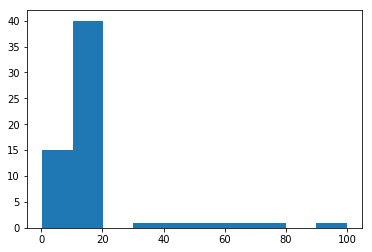

In [14]:
plt.figure(figsize=[6,4])
plt.hist(null_total_table['% Transf Null Values'],bins=10)
plt.show()
#Try 20 as threshold

In [51]:
# Investigate patterns in the amount of missing data in each column.
null_high_table=null_total_table[null_total_table['% Transf Null Values']>20]
null_high_list=list(null_high_table.index)
null_high_list

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_low_nan=azdias_nan.drop(null_high_list,axis=1)
azdias_low_nan.shape

(891221, 79)

In [17]:
#azdias_low_nan.columns.isin(null_high_list)

In [18]:
#Look for patterns in droppped columns
df2=pd.DataFrame(columns=feat_info.columns)
for attri in null_high_list:
    df1=feat_info.loc[feat_info['attribute']==attri]
    df2=df2.append(df1)#ignore_index=True
df2.sort_values('missing_or_unknown',ascending=True)

,attribute,information_level,type,missing_or_unknown
40,TITEL_KZ,person,categorical,"[-1,0]"
0,AGER_TYP,person,categorical,"[-1,0]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
47,KK_KUNDENTYP,household,categorical,[-1]
11,GEBURTSJAHR,person,numeric,[0]
43,ALTER_HH,household,interval,[0]


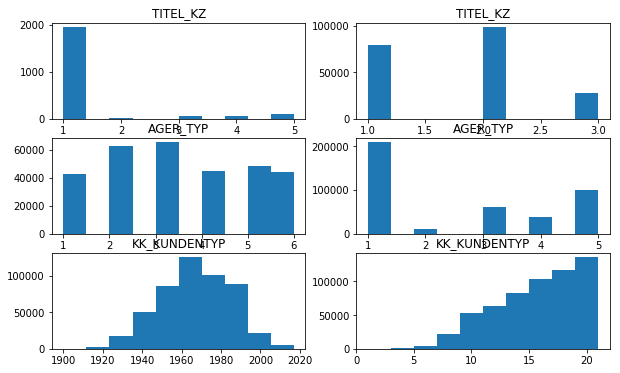

In [19]:
ncols = 2
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
cnt=0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        ax.hist(azdias_nan[null_high_list[cnt]].dropna(),bins=10)#hist don't handle nan
        ax.set_title(null_high_list[i])
        cnt+=1
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

I removed the columns with more than 20% missing values (6 columns): 'TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'.

I do not see any other common pattern between the dropped columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
# Count missing values by row
azdias_low_nan_by_row=azdias_low_nan.copy()
azdias_low_nan_by_row['Total nan by row'] = azdias_low_nan_by_row.isnull().sum(axis=1) #axis=1 by row

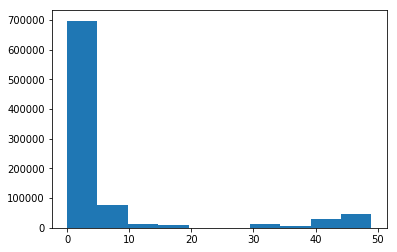

0.24691358024691357

In [21]:
plt.hist(azdias_low_nan_by_row['Total nan by row'],bins=10)
plt.show()
#Try 20 as threshold to divide the data=>Missing less than 25% of data
20/81

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold=20
azdias_low_nan_low_nan_by_row=azdias_low_nan_by_row[azdias_low_nan_by_row['Total nan by row']<=threshold]
azdias_low_nan_high_nan_by_row=azdias_low_nan_by_row[azdias_low_nan_by_row['Total nan by row']>threshold]
print(azdias_low_nan_low_nan_by_row.shape)
print(azdias_low_nan_high_nan_by_row.shape)

(797426, 80)
(93795, 80)


In [23]:
#Find 5 columns with low/non nan
azdias_low_nan_nan_by_col= azdias_low_nan_by_row.isnull().sum(axis=0) #axis=1 by column
azdias_non_nan_5_col=azdias_low_nan_nan_by_col[azdias_low_nan_nan_by_col==0].index[:5]
#azdias_non_nan_5_col

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_column(column_name,df_low_nan, df_high_nan):
    #fx to compare data from une of the two datasets
    fig,ax=plt.subplots(1, 2,figsize=(10, 6))
    ax1 = sns.countplot(x=column_name,data=df_low_nan,ax=ax[0])
    ax1.set_title('Low NaN dataset')
    ax2 = sns.countplot(x=column_name,data=df_high_nan,ax=ax[1])
    ax2.set_title('High NaN dataset')
    plt.show()

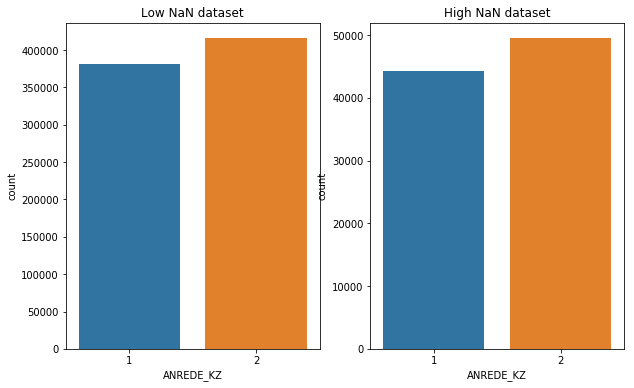

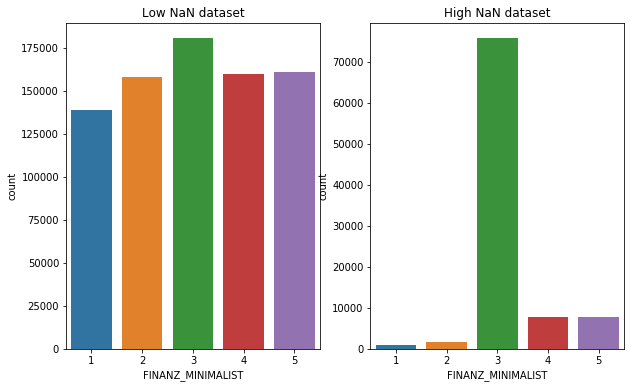

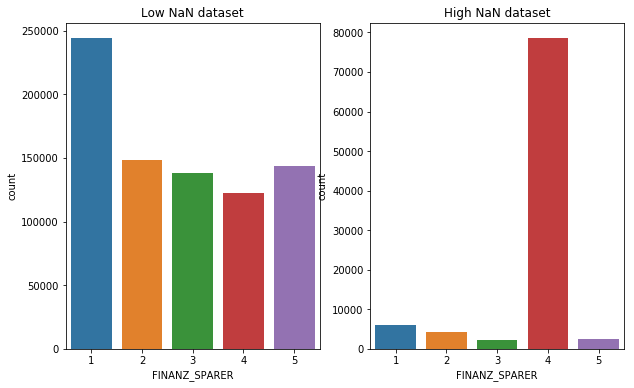

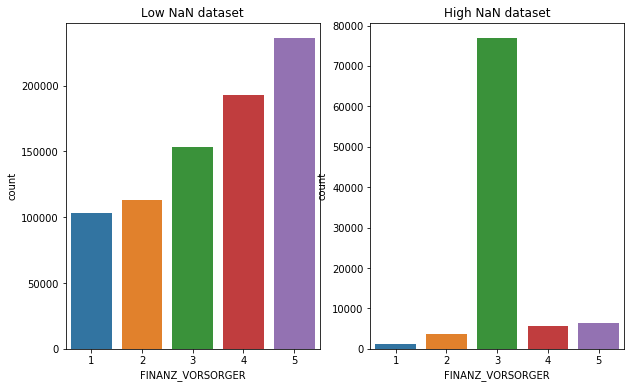

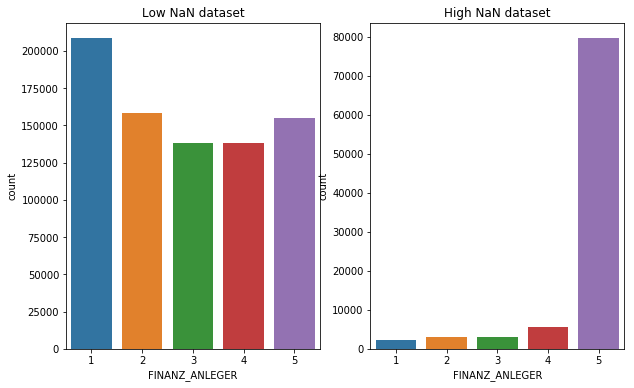

In [25]:
for col in azdias_non_nan_5_col:    
    compare_column(col,azdias_low_nan_low_nan_by_row,azdias_low_nan_high_nan_by_row)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Aprox 94.432 rows have more than 20 Nan data (out of 81 attributes, more than 25% of data) and aprox 796.789 rows have less or equal 20 Nan dad (out of 81 attributes, less than 25% of data)

4 out of 5 columns (with cero nan) have significantly different distribution of data between the two datasets, the hight Nan data tends to have one really dominant value. Only ANREDE_KZ has similar distribution between the two.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
azdias_total_low_nan=azdias_low_nan_low_nan_by_row.copy() #Keep using this data set
feat_info.groupby('type')['type'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_table=feat_info[feat_info['type']=='categorical']
cat_names=cat_table['attribute']
non_cat_names=feat_info['attribute'][feat_info['type']!='categorical']
#Drop the names in the list null_high_list
cat_names=[name for name in cat_names if name not in null_high_list]
non_cat_names=[name for name in non_cat_names if name not in null_high_list]

In [28]:
#df with categorical values
azdias_total_low_nan_cat=azdias_total_low_nan.drop(non_cat_names,axis=1)
#count the num of unique variables
azdias_total_low_nan_cat_unique_var=azdias_total_low_nan_cat.nunique()

In [29]:
azdias_total_low_nan_cat_unique_var.sort_values()

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
Total nan by row    21
CAMEO_DEU_2015      44
dtype: int64

In [30]:
#Non-numeric categorical variable=>OST_WEST_KZ
#Most ceros=>'SOHO_KZ','GREEN_AVANTGARDE'
attri='OST_WEST_KZ'
print(azdias_total_low_nan_cat[attri].describe())
print(azdias_total_low_nan_cat.groupby(attri)[attri].count())

count     797426
unique         2
top            W
freq      628987
Name: OST_WEST_KZ, dtype: object
OST_WEST_KZ
O    168439
W    628987
Name: OST_WEST_KZ, dtype: int64


In [31]:
#Change to 1 all the W in 'OST_WEST_KZ' column
azdias_total_low_nan['OST_WEST_KZ']=azdias_total_low_nan['OST_WEST_KZ'].replace('W',1).replace('O',0)

In [32]:
attri='OST_WEST_KZ'
print(azdias_total_low_nan[attri].describe())
print(azdias_total_low_nan.groupby(attri)[attri].count())

count     797426
unique         2
top            1
freq      628987
Name: OST_WEST_KZ, dtype: int64
OST_WEST_KZ
1    628987
O    168439
Name: OST_WEST_KZ, dtype: int64


In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Merge the table with unique values and the one with missing data 
azdias_total_low_nan_cat_multi_var=azdias_total_low_nan_cat_unique_var[azdias_total_low_nan_cat_unique_var>2]
#null_total_table
df_azdias_total_low_nan_cat_multi_var=pd.DataFrame(azdias_total_low_nan_cat_multi_var)
df_null_total_table=pd.DataFrame(null_total_table)

In [34]:
#Merge the table to see if it is worth including the attributes=>If is not worth it
table=df_azdias_total_low_nan_cat_multi_var.merge(df_null_total_table,how='left',left_index=True,right_index=True)

In [ ]:
#table.sort_values(0,ascending=True)

In [37]:
#Drop the attributes that have more than 3 levels
azdias_total_low_nan=azdias_total_low_nan.drop(table.index,axis=1)

In [38]:
#azdias_total_low_nan.columns

#### Discussion 1.2.1: Re-Encode Categorical Features

I re-enconde to number 1 the values in the column 'OST_WEST_KZ'.

I will drop all the columns with more than 3 levels to reduce complexity.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
mix_table=feat_info[feat_info['type']=='mixed']
#mix_table

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
attri='PRAEGENDE_JUGENDJAHRE'
print(azdias_total_low_nan[attri].nunique())
perc_nan=round(100*azdias_total_low_nan[attri].isnull().sum()/azdias_total_low_nan[attri].count(),2)
print(str(perc_nan)+"%")
azdias_total_low_nan[attri].describe()
azdias_total_low_nan.groupby(attri)[attri].count()

15
3.7%


PRAEGENDE_JUGENDJAHRE
1.0      20662
2.0       7479
3.0      53822
4.0      20450
5.0      84665
6.0      25651
7.0       4009
8.0     141542
9.0      33563
10.0     85767
11.0     35735
12.0     24440
13.0      5759
14.0    182903
15.0     42521
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [41]:
#Re-encode the PRAEGENDE_JUGENDJAHRE attribute and add 2 more variables
#PRAEGENDE_JUGENDJAHRE_GEN
#0(40-70):1-9
#1(80-90):10-15
azdias_total_low_nan['PRAEGENDE_JUGENDJAHRE_GEN']=np.where(azdias_total_low_nan['PRAEGENDE_JUGENDJAHRE']<=9,0,1) #To have only 2 levels

#PRAEGENDE_JUGENDJAHRE_MOV
#0(Avantgarde): 2,4,6,7,9,11,13,15
#1(Mainstream): 1,3,5,8,10,12,14
a=np.array(azdias_total_low_nan['PRAEGENDE_JUGENDJAHRE'])
azdias_total_low_nan['PRAEGENDE_JUGENDJAHRE_MOV']=np.where((a==2) | (a==4) | 
                                                           (a==6) | (a==7) | 
                                                           (a==9) | (a==11) | 
                                                           (a==13) | (a==15),0,1)

In [42]:
attri='PRAEGENDE_JUGENDJAHRE_GEN'
azdias_total_low_nan.groupby(attri)[attri].count()

PRAEGENDE_JUGENDJAHRE_GEN
0    391843
1    405583
Name: PRAEGENDE_JUGENDJAHRE_GEN, dtype: int64

In [43]:
attri='PRAEGENDE_JUGENDJAHRE_MOV'
azdias_total_low_nan.groupby(attri)[attri].count()

PRAEGENDE_JUGENDJAHRE_MOV
0    175167
1    622259
Name: PRAEGENDE_JUGENDJAHRE_MOV, dtype: int64

In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
attri='CAMEO_INTL_2015'
print(azdias_total_low_nan[attri].nunique())
perc_nan=round(100*azdias_total_low_nan[attri].isnull().sum()/azdias_total_low_nan[attri].count(),2)
print(str(perc_nan)+"%")
azdias_total_low_nan[attri].describe()
azdias_total_low_nan.groupby(attri)[attri].count()

21
0.76%


CAMEO_INTL_2015
12     13234
13     26311
14     62851
15     16966
22     33137
23     26667
24     91099
25     39605
31     18979
32     10346
33      9928
34     18517
35     10352
41     92309
43     56653
44     14817
45     26126
51    133673
52     20538
54     45376
55     23939
Name: CAMEO_INTL_2015, dtype: int64

In [45]:
#Re-encode the CAMEO_INTL_2015 attribute and add 2 more variables=> Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
azdias_total_low_nan['CAMEO_INTL_2015']=azdias_total_low_nan['CAMEO_INTL_2015'].astype(str)
azdias_total_low_nan['CAMEO_INTL_2015_WE']=azdias_total_low_nan['CAMEO_INTL_2015'].str[0]
azdias_total_low_nan['CAMEO_INTL_2015_ST']=azdias_total_low_nan['CAMEO_INTL_2015'].str[1]

azdias_total_low_nan['CAMEO_INTL_2015_WE']=azdias_total_low_nan['CAMEO_INTL_2015_WE'].replace('n',np.nan)
azdias_total_low_nan['CAMEO_INTL_2015_ST']=azdias_total_low_nan['CAMEO_INTL_2015_ST'].replace('a',np.nan)

In [46]:
attri='CAMEO_INTL_2015_WE'
azdias_total_low_nan.groupby(attri)[attri].count()

CAMEO_INTL_2015_WE
1    119362
2    190508
3     68122
4    189905
5    223526
Name: CAMEO_INTL_2015_WE, dtype: int64

In [47]:
attri='CAMEO_INTL_2015_ST'
azdias_total_low_nan.groupby(attri)[attri].count()

CAMEO_INTL_2015_ST
1    244961
2     77255
3    119559
4    232660
5    116988
Name: CAMEO_INTL_2015_ST, dtype: int64

In [48]:
# Drop the rest of the mixed-variables
mix_names=list(mix_table['attribute'])
#mix_names

In [49]:
#azdias_total_low_nan.drop(mix_names)
mix_names=[name for name in mix_names if name not in null_high_list]
#mix_names

In [50]:
azdias_total_low_nan=azdias_total_low_nan.drop(mix_names,axis=1)
#azdias_total_low_nan.columns.isin(mix_names)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I droped all the mixed type attributes except the ones I discussed above to reduce complexity of the problem

Re-encode PRAEGENDE_JUGENDJAHRE attribute and add 2 more variables (2 levels)

PRAEGENDE_JUGENDJAHRE_GEN => I used a conditional function to select the appropiate level
- 0(40-70):1-9
- 1(80-90):10-15

PRAEGENDE_JUGENDJAHRE_MOV => I used a multi-conditional function (with OR logical) to select the appropiate level
- 0(Avantgarde): 2,4,6,7,9,11,13,15
- 1(Mainstream): 1,3,5,8,10,12,14

Re-encode the CAMEO_INTL_2015 attribute and add 2 more variables: CAMEO_INTL_2015_WE and CAMEO_INTL_2015_ST
=> Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [71]:
#I did all the data engineering required
df_azdias_total_low_nan=pd.DataFrame(azdias_total_low_nan.columns)
df=feat_info.merge(df_azdias_total_low_nan, left_on='attribute',right_on=0)
df
azdias_total_low_nan.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
def clean_data(df,feat_info,attri_threshold,row_threshold):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data 
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # CONVERT MISSING value codes into NaNs, ...
    #Get the X values
    miss_unk_table=feat_info.groupby('missing_or_unknown')['missing_or_unknown'].count()
    miss_unk=list(miss_unk_table.index[miss_unk_table==1])
    miss_unk_X=miss_unk[1:]
    #Find the attri that have X as miss_unk
    attri_names_X=[]
    for i in range(len(miss_unk_X)):
        attri_index_X=list(feat_info['missing_or_unknown']).index(miss_unk_X[i])
        attri_name_X=feat_info['attribute'][attri_index_X]
        attri_names_X.append(attri_name_X)
    attri_names=list(feat_info['attribute'].loc[feat_info['missing_or_unknown']!='[]'])#All names except blanks
    attri_names=[name for name in attri_names if name not in attri_names_X]#Drop the names in the list
    
    #Replace miss_unk to nan if there are int64 variables
    for attri in attri_names:
    #parse de miss_unkonw variable. NEED the np.int64
        mis_unk=list(map(np.int64,list(feat_info['missing_or_unknown'][feat_info['attribute']==attri])[0].replace('[','').replace(']','').split(',')))
        for j in range(len(mis_unk)):
            df[attri]=df[attri].replace(mis_unk[j],np.nan)
    #Replace miss_unk to nan if there are X as unknown
    for attri in attri_names_X:
        mis_unk=list(feat_info['missing_or_unknown'][feat_info['attribute']==attri])[0].replace('[','').replace(']','').split(',')
        for j in range(len(mis_unk)):
            df[attri]=df[attri].replace(mis_unk[j],np.nan)
    
    # REMOVE selected columns and rows, ...
    #High null columns, more than 20% of missing values in each col
    null_col = round(100 * df.isnull().sum() / len(df),2)
    null_high_list=list(null_col[null_col>attri_threshold].index)
    #print(null_col[null_col>attri_threshold].count())
    df=df.drop(null_high_list,axis=1)
    #print(df.shape)
    
    #High null rows, keep  rows with less of equal 'row_threshold' of missing values
    df['Total nan by row'] = df.isnull().sum(axis=1) #axis=1 by row
    df=df[df['Total nan by row']<=row_threshold]
    df=df.drop('Total nan by row',axis=1)
    #print(df.shape)
    
    # SELECT, re-encode, and engineer column values.
    #Categorical features
    non_cat_names=list(feat_info['attribute'][feat_info['type']!='categorical'])
    non_cat_names=[name for name in non_cat_names if name not in null_high_list] #Drop the names in the list null_high_list 
    df_cat=df.drop(non_cat_names,axis=1) #df with categorical values
    cat_unique=df_cat.nunique()
    cat_multi=cat_unique[df_cat.nunique()>2]#list of cat variables with more than 2 levels
    df=df.drop(cat_multi.index,axis=1) #Drop the attributes that have more than 2 levels
    #print(df.shape)

    df['OST_WEST_KZ']=df['OST_WEST_KZ'].replace('W',1).replace('O',0).astype(int) #Change to 1 all the W and to 0 all the O in 'OST_WEST_KZ' column
    
    #Mixed features
    df['PRAEGENDE_JUGENDJAHRE_GEN']=np.where(df['PRAEGENDE_JUGENDJAHRE']<=9,0,1)
    a=np.array(df['PRAEGENDE_JUGENDJAHRE'])
    df['PRAEGENDE_JUGENDJAHRE_MOV']=np.where((a==2) | (a==4) | 
                                             (a==6) | (a==7) | 
                                             (a==9) | (a==11) | 
                                             (a==13) | (a==15),0,1)
        
    df['CAMEO_INTL_2015']=df['CAMEO_INTL_2015'].astype(str)
    df['CAMEO_INTL_2015_WE']=df['CAMEO_INTL_2015'].str[0].astype(int).replace('n',np.nan)
    df['CAMEO_INTL_2015_ST']=df['CAMEO_INTL_2015'].str[1].astype(int).replace('a',np.nan)
    
    #Drop the mixed features
    mix_names=list(feat_info['attribute'][feat_info['type']=='mixed'])
    mix_names=[name for name in mix_names if name not in null_high_list]
    df=df.drop(mix_names,axis=1)
    #print(df.shape)
    
    # RETURNS the cleaned dataframe.
    return df    

In [3]:
#TEST and quick method to clean the first database too
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
row_threshold=0 #0: We want a completely clean database by row
                #20: if we admit a 20% or less of missing data by row
attri_threshold=30 #Previously 20%, increased due to customers data lack of data in important features (Nothing changes here)
azdias_cleaned=clean_data(azdias,feat_info,attri_threshold,row_threshold)

In [ ]:
azdias_cleaned.shape #With 20% of nan in each row at most
#(891221, 79)
#(797426, 79)
#(797426, 66)
#(797426, 64)

In [5]:
azdias_cleaned.shape #With 0% of nan in each row at most
#(891221, 79)
#(623209, 79)
#(623209, 66)
#(623209, 64)

(623209, 64)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#Already cleaned
#azdias_cleaned.info()

In [6]:
# Apply feature scaling to the general population demographics data.
scaler=StandardScaler(copy=True, with_mean=True, with_std=True) #mean=use the feature mean, std=use the feature std
azdias_scaled=scaler.fit_transform(azdias_cleaned)

In [7]:
#To have the names of the attributes
keys=list(range(0,azdias_cleaned.shape[1]))
values=list(azdias_cleaned.columns)
name_dic=dict(zip(keys,values))

In [8]:
#azdias_scaled #np.array with the numbers 
azdias_scaled=pd.DataFrame(azdias_scaled)
azdias_scaled = azdias_scaled.rename(columns = name_dic)

### Discussion 2.1: Apply Feature Scaling

I already cleaan all the rows with missing or null data (aprox 11% of the rows, 93.795) and I applied the .fit_transform() function to the cleaned database

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [11]:
# Apply PCA to the data.
pca=PCA()#n_components=ALl
azdias_pca=pca.fit_transform(azdias_scaled)

In [10]:
def pca_chart(pca):    
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

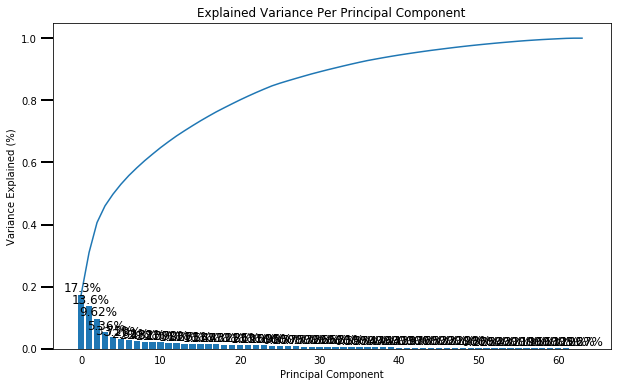

In [13]:
# Investigate the variance accounted for by each principal component.
pca_chart(pca)

In [18]:
def do_pca(comp,df):
    pca=PCA(n_components=comp)
    azdias_pca=pca.fit_transform(azdias_scaled)
    return pca, azdias_pca

def pca_results(df, pca):
    #Create a DataFrame of the PCA results
    #Includes dimension feature weights and explained variance
    #Visualizes the PCA results

    # Dimension indexing
    dimensions = dimensions = ['Components {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1) 

In [15]:
pca_results(azdias_scaled, pca)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_WE,CAMEO_INTL_2015_ST
Components 1,0.1739,-0.1453,-0.0035,-0.2219,0.1632,-0.1340,0.0846,0.0924,0.1468,-0.1152,...,0.2089,0.0358,-0.1638,0.1383,0.1856,0.1259,0.1189,0.1152,0.1983,-0.1259
Components 2,0.1363,0.2468,0.0929,0.0424,-0.2182,0.2149,-0.1923,-0.2176,0.1282,-0.0309,...,0.1102,0.0144,-0.0903,0.0812,0.1081,0.0762,-0.2272,0.0309,0.0902,-0.0163
Components 3,0.0962,0.0862,-0.3675,0.1584,-0.1042,0.1013,-0.1906,-0.0958,-0.0477,0.0504,...,0.0470,0.0066,-0.0381,0.0334,0.0495,0.0319,-0.1002,-0.0504,0.0252,-0.0097
Components 4,0.0537,-0.0410,0.0431,0.0586,-0.0014,-0.0194,-0.1293,0.0882,-0.1009,0.3920,...,0.0856,0.1289,0.0226,0.0511,0.2502,0.0934,0.0494,-0.3920,-0.1307,0.0618
Components 5,0.0375,-0.0015,-0.0074,-0.0828,0.0004,0.0597,-0.0486,0.0428,0.0843,-0.0580,...,-0.0154,0.4964,0.3982,-0.2067,-0.0888,-0.1393,-0.0281,0.0580,0.0079,-0.0281
Components 6,0.0320,-0.0035,0.0196,-0.0324,0.0034,-0.0279,0.0252,-0.0391,0.0502,0.0049,...,0.0915,-0.0239,-0.0801,-0.1803,-0.0823,-0.2197,0.0090,-0.0049,-0.0696,0.0499
Components 7,0.0281,0.0090,-0.0528,0.0529,0.0581,-0.0077,0.0703,0.0478,-0.1943,-0.0275,...,0.0406,0.2085,0.1260,-0.0002,0.1183,0.0265,0.0491,0.0275,0.0178,-0.0690
Components 8,0.0248,0.1275,0.0031,-0.0607,0.0784,-0.1189,0.1469,0.0026,0.0548,0.0495,...,0.1099,0.1442,0.0162,0.0755,-0.0907,-0.0044,0.0927,-0.0495,0.0848,-0.0170
Components 9,0.0232,-0.0070,0.0932,0.0588,-0.1298,0.1124,-0.0581,-0.1136,0.0621,0.0025,...,0.0109,0.1290,0.0850,0.1237,0.0817,0.0675,-0.0756,-0.0025,0.0090,0.0381
Components 10,0.0214,0.0569,0.0081,-0.0217,0.0028,0.1026,-0.0803,0.1016,-0.0659,-0.0461,...,-0.0430,-0.2534,-0.1563,-0.4119,-0.0724,-0.1607,0.0080,0.0461,0.0536,-0.1860


In [19]:
#Find the number of dimensions/components necesary to explain at least cum_var% of variability of data
cum_var=0.85
comp=3
for comp in range(comp, azdias_scaled.shape[1]):
    pca, azdias_pca = do_pca(comp, azdias_scaled)
    comp_wi = pca_results(azdias_scaled, pca) #Table with dimensions and attribute sensibility
    if comp_wi['Explained Variance'].sum() > cum_var:
        break
num_comp = comp_wi.shape[0]
print(num_comp)

26


In [20]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, azdias_pca = do_pca(26, azdias_scaled)

In [21]:
 comp_wi=pca_results(azdias_scaled, pca)

### Discussion 2.2: Perform Dimensionality Reduction

I will retain 26 components for the next steps because they explain at least 85% of the data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [22]:
def comp_analysis(df,comp_num):
    comp_num=comp_num-1
    comp_name=df.index[comp_num]
    comp=df.iloc[comp_num,].drop('Explained Variance').sort_values(ascending=False)
    #Pick top and bottom 5
    comp_top=pd.DataFrame(comp.iloc[:5,]).rename(columns={comp_name:'wi'})#Top
    comp_bottom=pd.DataFrame(comp.iloc[-5:,]).rename(columns={comp_name:'wi'})#Bottom
    #merge tables 
    table_top=feat_info.merge(comp_top,how='right',left_on='attribute',right_index=True)
    table_bottom=feat_info.merge(comp_bottom,how='right',left_on='attribute',right_index=True)
    #select features
    features_list=['attribute','information_level','wi']
    table_top=table_top[features_list].sort_values('information_level',ascending=False)
    table_bottom=table_bottom[features_list].sort_values('information_level',ascending=True)
    return table_top,table_bottom

In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
table_top,table_bottom=comp_analysis(comp_wi,1)
table_top # (+) Higly correlated macrocell_plz8

,attribute,information_level,wi
77,PLZ8_ANTG3,macrocell_plz8,0.2151
78,PLZ8_ANTG4,macrocell_plz8,0.2089
46,HH_EINKOMMEN_SCORE,household,0.1957
83,ORTSGR_KLS9,community,0.1856
84,CAMEO_INTL_2015_WE,NaN,0.1983


In [24]:
table_bottom # (-) correlated microcell_rr3

,attribute,information_level,wi
75,PLZ8_ANTG1,macrocell_plz8,-0.2168
60,KBA05_ANTG1,microcell_rr3,-0.2196
65,KBA05_GBZ,microcell_rr3,-0.2094
4,FINANZ_MINIMALIST,person,-0.2219
71,MOBI_REGIO,region_rr1,-0.2344


In [28]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
table_top,table_bottom=comp_analysis(comp_wi,2)
table_top.sort_values('wi',ascending=False) # (+) person

,attribute,information_level,wi
1,ALTERSKATEGORIE_GROB,person,0.2468
30,SEMIO_ERL,person,0.2274
6,FINANZ_VORSORGER,person,0.2149
29,SEMIO_LUST,person,0.1690
23,RETOURTYP_BK_S,person,0.1612


In [30]:
table_bottom.sort_values('wi',ascending=True) # (-) person

,attribute,information_level,wi
26,SEMIO_REL,person,-0.2552
36,SEMIO_PFLICHT,person,-0.2273
84,PRAEGENDE_JUGENDJAHRE_GEN,NaN,-0.2272
37,SEMIO_TRADV,person,-0.2213
5,FINANZ_SPARER,person,-0.2182


In [31]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
table_top,table_bottom=comp_analysis(comp_wi,3)
table_top.sort_values('wi',ascending=False) # (+) 

,attribute,information_level,wi
28,SEMIO_VERT,person,0.3477
24,SEMIO_SOZ,person,0.2624
25,SEMIO_FAM,person,0.2487
31,SEMIO_KULT,person,0.2286
4,FINANZ_MINIMALIST,person,0.1584


In [21]:
table_bottom.sort_values('wi',ascending=True) # (-)

,attribute,information_level,wi
2,ANREDE_KZ,person,-0.3675
32,SEMIO_RAT,person,-0.2226
33,SEMIO_KRIT,person,-0.2676
34,SEMIO_DOM,person,-0.3120
35,SEMIO_KAEM,person,-0.3364


### Discussion 2.3: Interpret Principal Components

COMPONENT 1  is more negative correlated to low financial interest and movements of small families and positive correlated to wealthy big families. 

COMPONENT 2 is more negative correlated to religous, dutful, tradition, money saver generation (Probably old generation people) and positive correlated to age, event-oriented, type of buyer and be prepared type of financial typology (Probably young people)

COMPONENT 3 is more negative correlated to gender, rational,critical, dominant and combative type of personality and positive correlated to dreamful, socially and family minded, cultural with low financtial interest.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [27]:
def clusters_score(df,center):
 #Recurs the average score to the centers
    kmeans=KMeans(n_clusters=center)
    model=kmeans.fit(df)    
    # Obtain a score related to the model fit
    scores = np.abs(model.score(df))
    return scores

In [ ]:
def plot_3dim(df, labels):
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(df[:, 0], df[:, 1], df[:, 2], c=labels, cmap='tab10');

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


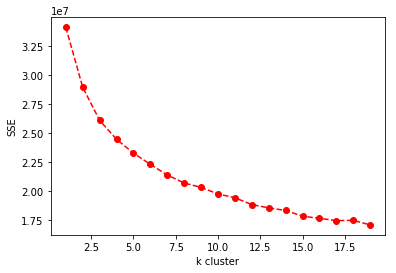

In [29]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Use the Elbow method
scores=[]
centers=list(range(1,20))
for center in centers:
    scores.append(clusters_score(azdias_pca,center))
    print(center)
plt.plot(centers,scores, linestyle='--',marker='o',color='r')
plt.xlabel('k cluster')
plt.ylabel('SSE')
plt.show()

In [98]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_centers=8
kmeans=KMeans(n_clusters=n_centers)
model=kmeans.fit(azdias_pca)
labels=model.predict(azdias_pca)

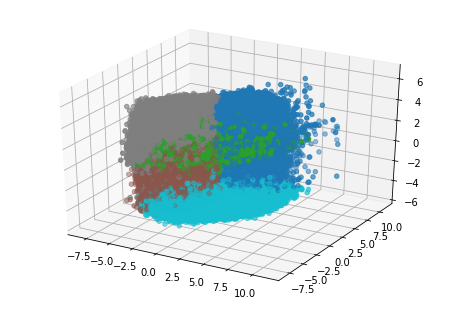

In [35]:
plot_3dim(azdias_pca, labels) #Just using the 3 first dimensions. Just to see how it looks like

### Discussion 3.1: Apply Clustering to General Population

Using the Elbow method in the pca-transformed data I decided to segment the population in 8 clusters for simplicity

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [32]:
customers.shape

(191652, 85)

In [33]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
row_threshold=0 #0: We want a completely clean database by row
attri_threshold=35
customers_cleaned=clean_data(customers,feat_info,attri_threshold,row_threshold) #There are 53 features with more than 20% of missing data 
                                                                #so I would increase threshold to 30% 
                                                                #to match the features dropped throught the cleaning face 

In [34]:
customers_cleaned.shape

(115643, 64)

In [126]:
#To have the names of the attributes
keys=list(range(0,customers_cleaned.shape[1]))
values=list(customers_cleaned.columns)
name_dic=dict(zip(keys,values))

In [129]:
#scaler=StandardScaler(copy=True, with_mean=True, with_std=True)
customers_scaled=pd.DataFrame(scaler.transform(customers_cleaned))
customers_scaled=customers_scaled.rename(columns = name_dic)

#pca=PCA(n_components=26) #I keep this object
customers_pca=pca.transform(customers_scaled)

#kmeans=KMeans(n_clusters=8) #I keep this object
#model=kmeans.fit(azdias_pca) #I keep this object
labels_customers=model.predict(customers_pca)

In [130]:
labels_customers

array([6, 1, 3, ..., 6, 1, 6], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

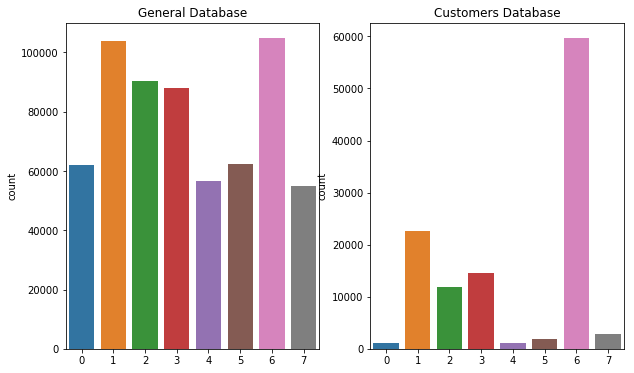

In [131]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig,ax=plt.subplots(1, 2,figsize=(10, 6))
ax1 = sns.countplot(x=labels,ax=ax[0])
ax1.set_title('General Database')
ax2 = sns.countplot(x=labels_customers,ax=ax[1])
ax2.set_title('Customers Database')
plt.show()

In [102]:
df_labels=pd.DataFrame(labels) #For general data
df_labels=df_labels.rename(columns={0:'Labels'})
cluster_table = pd.DataFrame([], index=sorted(df_labels['Labels'].unique()))
# looping through cluster
for cluster in df_labels['Labels'].unique():
    cluster_table.loc[cluster, "Count"] = df_labels[df_labels['Labels']==cluster]['Labels'].count()
    cluster_table.loc[cluster, "% of data"] = round(df_labels[df_labels['Labels']==cluster]['Labels'].count()/df_labels.shape[0]*100,2)
print(df_labels.shape[0])
print(cluster_table)

623209
      Count  % of data
0   61880.0       9.93
1  103967.0      16.68
2   90358.0      14.50
3   88013.0      14.12
4   56668.0       9.09
5   62478.0      10.03
6  104811.0      16.82
7   55034.0       8.83


In [103]:
df_labels_customers=pd.DataFrame(labels_customers) #For customers data
df_labels_customers=df_labels_customers.rename(columns={0:'Labels_customers'})
cluster_table_customers = pd.DataFrame([], index=sorted(df_labels_customers['Labels_customers'].unique()))
# looping through cluster
for cluster in df_labels_customers['Labels_customers'].unique():
    cluster_table_customers.loc[cluster, "Count"] = df_labels_customers[df_labels_customers['Labels_customers']==cluster]['Labels_customers'].count()
    cluster_table_customers.loc[cluster, "% of data"] = round(df_labels_customers[df_labels_customers['Labels_customers']==cluster]['Labels_customers'].count()/df_labels_customers.shape[0]*100,2)
print(df_labels_customers.shape[0])
print(cluster_table_customers)

115643
     Count  % of data
0   1060.0       0.92
1  22637.0      19.57
2  11847.0      10.24
3  14651.0      12.67
4   1094.0       0.95
5   1859.0       1.61
6  59659.0      51.59
7   2836.0       2.45


In [132]:
df_to_comp=model.cluster_centers_
df_to_attri=scaler.inverse_transform(pca.inverse_transform(df_to_comp))
df_to_attri.shape #(5, 64)=> 5 clusters , 64 features
df_to_dim.shape #(5, 26)=> 5 clusters , 26 components in PCA

(8, 26)

In [149]:
def pca_chart(df, pca, component_no):
    '''
    Create a DataFrame of the PCA results
    Visualizes the PCA results for a speacific component number for a speacific number of features
    '''    
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    # Capturing most interesting features which at the end and beginning of sorted list
    pca_comp = pd.concat([pca_comp.head(5), pca_comp.tail(5)])
    
    pca_comp.plot(kind='barh', 
                  title='Most 10 wi features for PCA component {}'.format(component_no),
                  figsize=(6, 3));
    plt.show()

In [142]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# People in cluster 3 are overrepresented in customer data
cluster=6#6 cluster
a=list(np.abs(list(df_to_comp[cluster])))
comp=a.index(max(a))+1 #max wi index 
print(comp)  #=> Neg to First component of PCA
print(df_to_comp[cluster,comp-1])

1
-3.44636872864


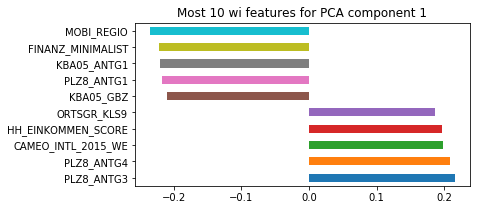

In [150]:
pca_chart(customers_scaled, pca, comp)

In [152]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster=0#0 cluster
a=list(np.abs(list(df_to_comp[cluster])))
comp=a.index(max(a))+1 #max wi index 
print(comp)  #=> Posit to First component of PCA
print(df_to_comp[cluster,comp-1])

1
4.60874089775


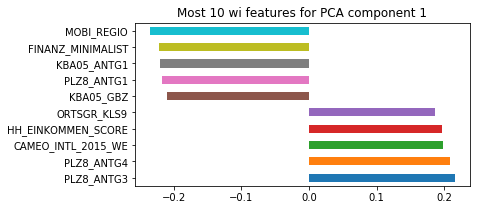

In [153]:
pca_chart(customers_scaled, pca, comp)

In [154]:
cluster=4 #4 cluster
a=list(np.abs(list(df_to_comp[cluster])))
comp=a.index(max(a))+1 #max wi index 
print(comp)  #Posit to First component of PCA
print(df_to_comp[cluster,comp-1])

1
4.53702553198


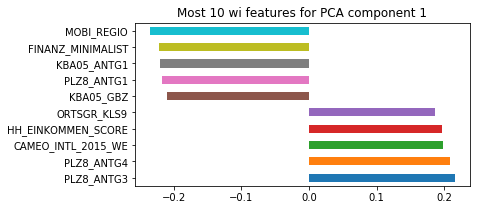

In [156]:
pca_chart(customers_scaled, pca, comp)

### Discussion 3.3: Compare Customer Data to Demographics Data

I had to increase the missing data threshold by attribution to 30% (from 20%) so the customers data is similar to the general data.

People in cluster 6 are very popular,they represent more than 50% of the customers, this type of people are oposite to the description provided in exercise 2.3 for COMPONENT 1. This type of people have low financial interest and movements of small families and negative correlated to wealthy big families.

On the other hand clusters 0  and 4 are underrepresented and are negative correlated to COMPONENT 1, this type of people are big wealthy families.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.